In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy import stats
from sklearn.manifold import TSNE
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

%matplotlib inline
sns.set(style="whitegrid")

In [3]:
# LOAD DATA BELOW
df = pd.read_csv(# ENTER DIRECTORY)

# **Clustering**

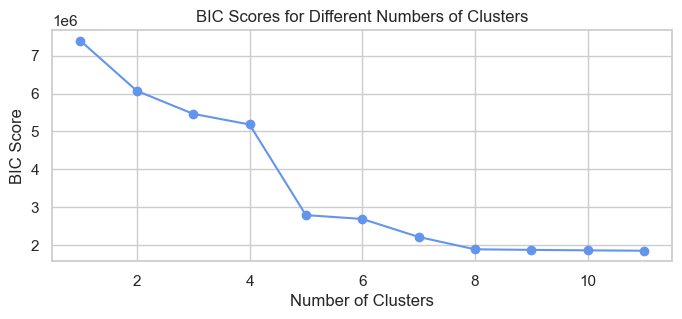

In [7]:
df_unscaled = df.copy()
cluster_variables = [# ENTER RELEVANT COLUMN NAMES HERE]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

bic_scores = []
n_components_range = range(1, 12) 

# Fit GMM with n clusters
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=10)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))

# Plot BIC scores
plt.figure(figsize=(8, 3))
plt.plot(n_components_range, bic_scores, marker='o', color = '#6495ED')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC Score')
plt.title('BIC Scores for Different Numbers of Clusters')
plt.show()

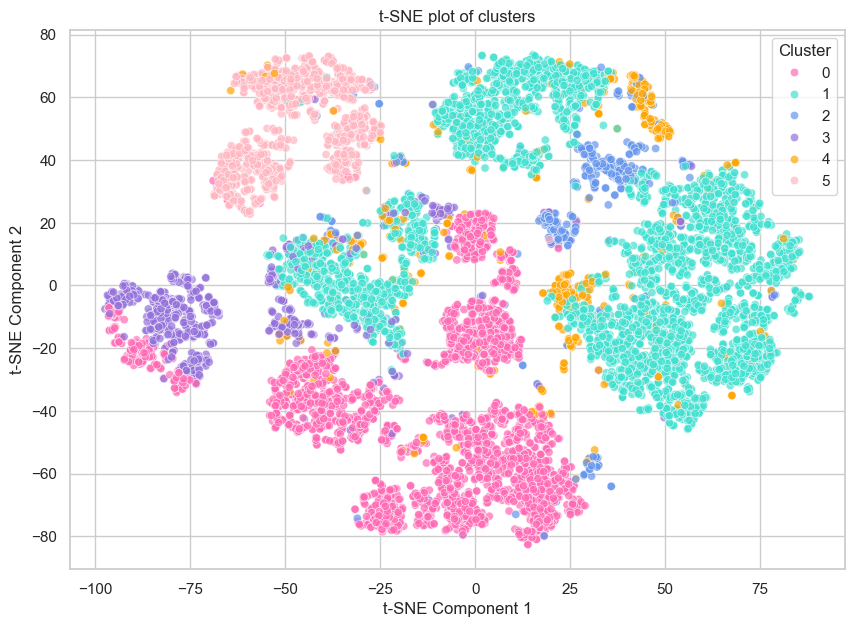

In [8]:
# Fit GMM with the best number of clusters
gmm = GaussianMixture(n_components=6, random_state=10)
gmm.fit(X_scaled)

# Predict clusters and add to dataset
df['segment'] = gmm.predict(X_scaled)

# Save 'segment' column to data
df.to_csv("segmented_data.csv", index=False)

# Sample 10,000 rows for t-SNE visualization only
df_sample = cleaned_data.sample(n=10000, random_state=10).copy()
X_sample = df_sample[cluster_variables].values
X_sample_scaled = scaler.transform(X_sample)

# Create t-SNE plot to visualize clusters
tsne = TSNE(n_components=2, random_state=10, perplexity=30, max_iter=1000)
X_tsne_sample = tsne.fit_transform(X_sample_scaled)

# Add t-SNE components to DataFrame
df_sample['tsne_1'] = X_tsne_sample[:, 0]
df_sample['tsne_2'] = X_tsne_sample[:, 1]

# Custom cluster color palette
custom_palette = {0: '#FF69B4',
                  1: '#40E0D0', 
                  2: '#6495ED',  
                  3: '#9370DB',  
                  4: '#FFA500', 
                  5: '#FFB6C1'}

# Plot with seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_sample, x='tsne_1', y='tsne_2', hue='segment', palette=custom_palette, alpha=0.7)
plt.title('t-SNE plot of clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

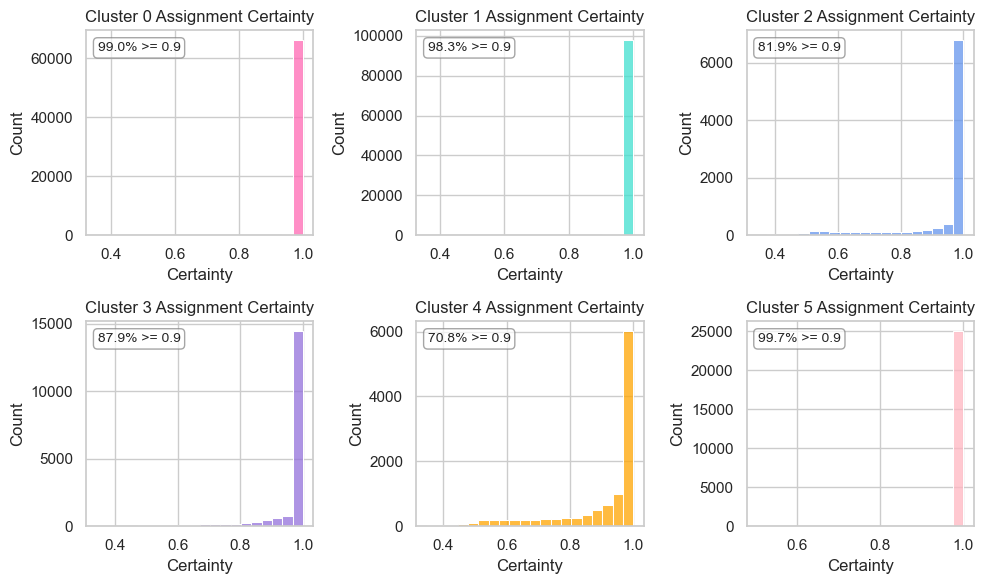

In [11]:
# Get cluster assignment probabilities
probs = gmm.predict_proba(X_scaled)

# Add assignment probability to the dataset
segmented_data['assignment_probability'] = probs.max(axis=1)

plt.figure(figsize=(10, 6))
for i in range(gmm.n_components):
    # Get assignment probabilities for current cluster
    cluster_probs = cleaned_data.loc[cleaned_data['segment'] == i, 'assignment_probability']

    # Compute histogram counts to set y-axis dynamically
    counts, _ = np.histogram(cluster_probs, bins=20)
    y_max = counts.max() + counts.max() * 0.05  # Add 5% padding

    plt.subplot(2, 3, i+1)
    sns.histplot(cluster_probs, bins=20, kde=False, color=custom_palette[i])
    plt.title(f'Cluster {i} Assignment Certainty')
    plt.xlabel('Certainty')
    plt.ylabel('Count')
    plt.ylim(0, y_max)

    pct_full_certainty = (cluster_probs >= 0.90).mean() * 100
    plt.text(
        0.05, 0.9, 
        f'{pct_full_certainty:.1f}% >= 0.9',
        transform=plt.gca().transAxes,
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
    )
plt.tight_layout()
plt.show()

# **Modeling**

In [15]:
def compute_lorenz(df, y_true_col, y_pred_col, weight_col):
    # Sort by predicted losses ascending
    df_sorted = df.sort_values(by=y_pred_col, ascending=True).copy()

    # Get columns
    capped_loss = df_sorted[y_true_col].values
    ee = df_sorted[weight_col].values

    # Total earned exposure and total losses
    total_ee = np.sum(ee)
    total_loss = np.sum(capped_loss)

    # Cumulative sums for Lorenz curve
    cum_ee = np.cumsum(ee) / total_ee
    cum_loss = np.cumsum(capped_loss) / total_loss

    return cum_ee, cum_loss

def plot_lorenz_curve(cum_ee, cum_loss, label=None, color=None):
    plt.plot(cum_ee, cum_loss, label=label, color=color)
    plt.plot([0,1], [0,1], 'k--', alpha=0.5)  # Line of equality
    plt.xlabel('Cumulative Fraction of Earned Exposure')
    plt.ylabel('Cumulative Fraction of Total Loss')
    if label:
        plt.legend()
    plt.grid(True)
    plt.title('Lorenz Curve')

def gini_coefficient(cum_ee, cum_loss):
    # Trapezoidal area between Lorenz curve and line of equality
    lorenz_area = np.trapz(cum_loss, cum_ee)
    return 1 - 2 * lorenz_area  # Gini = 1 - 2*A

In [16]:
# 100-bin R²
def binned_r2(actual, pred, n_bins=100):
    # Sort indices by predicted value (ascending)
    sorted_indices = np.argsort(pred)
    
    # Sort actual and predicted arrays according to indices
    actual_sorted = actual[sorted_indices]
    pred_sorted = pred[sorted_indices]
    
    # Split sorted data into 100 bins of approx equal size
    bins = np.array_split(np.arange(len(actual)), n_bins)
    
    y_bin_means = []
    pred_bin_means = []

    # Calculate actual and predicted means for each bin 
    for b in bins:
        y_bin_means.append(np.mean(actual_sorted[b]))
        pred_bin_means.append(np.mean(pred_sorted[b]))

    y_bin_means = np.array(y_bin_means)
    pred_bin_means = np.array(pred_bin_means)

    # Compute R²
    r2 = r2_score(y_bin_means, pred_bin_means)

    return r2


Segment 0:
Best Tweedie Power: 1.50, Gini: 0.2542, RMSE: 15918.3419, 100-bin R²: 0.7956

Segment 1:
Best Tweedie Power: 1.25, Gini: 0.2341, RMSE: 20653.9013, 100-bin R²: 0.9195

Segment 2:
Best Tweedie Power: 1.35, Gini: 0.5852, RMSE: 43932.9517, 100-bin R²: 0.9375

Segment 3:
Best Tweedie Power: 1.73, Gini: 0.2566, RMSE: 21485.6777, 100-bin R²: 0.5699

Segment 4:
Best Tweedie Power: 1.82, Gini: 0.2656, RMSE: 26420.8321, 100-bin R²: 0.3303

Segment 5:
Best Tweedie Power: 1.53, Gini: 0.2425, RMSE: 25444.1016, 100-bin R²: 0.5785

Combined Model Gini coefficient: 0.4593


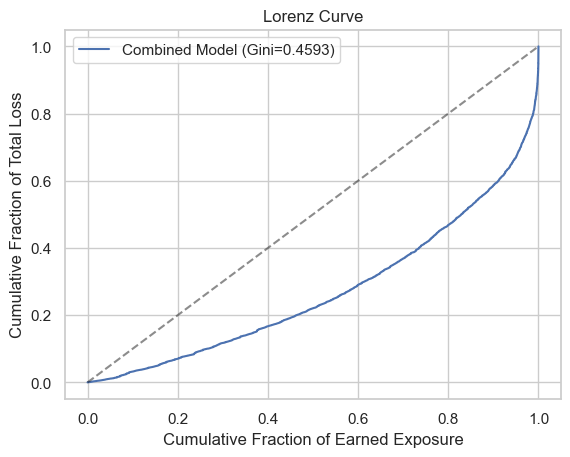

In [17]:
np.random.seed(10) # Set seed for reproducibility

# Load in final cleaned dataset with cluster assignments
df_final = pd.read_csv(# ENTER DIRECTORY HERE)

excluded = [# ENTER COLUMN NAMES THAT SHOULD BE EXCLUDED]
            
# Calculate target using offsets -> annualized_loss = capped_loss / (offset term)
df_final['annualized_loss'] = df_final['capped_loss'] / (df_final['offset term'])

# Create log_credit
df_final['log_credit'] = np.log(df_final['credit'])

# Create list of feature columns
features = [col for col in df_final.columns if col not in excluded]

# Standardize numerical variables
no_scale = [# ENTER COLUMN NAMES THAT DON'T NEED TO BE SCALED]
numeric_cols = df_final.select_dtypes(include=['number']).columns.tolist()
binary_cols = [col for col in numeric_cols if set(df_final[col].dropna().unique()).issubset({0, 1})]
cols_to_scale = [col for col in numeric_cols if col not in no_scale + binary_cols]
scaler = StandardScaler()
df_final[cols_to_scale] = scaler.fit_transform(df_final[cols_to_scale])

segments = sorted(df_final['segment'].unique())
best_models = {}

# Fit model on each segment
for seg in segments:
    print(f"\nSegment {seg}:")
    
    # Subset data for this segment
    df_segmented = df_final[df_final['segment'] == seg]
    
    # Define input features (X) and response variable (y)
    X = df_segmented[features]
    y = df_segmented['annualized_loss']

    # Split data into 80/20 training and test datasets
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)

    # Create 5 k-folds
    kf = KFold(n_splits=5, shuffle=True, random_state=10)
    
    # Random Grid Search: tune hyperparameters
    random_params = []
    for _ in range(30):
        params = {'tweedie_variance_power': np.random.uniform(1.1, 2.0),'learning_rate': np.random.uniform(0.01, 0.1),'num_leaves': np.random.randint(20, 100)}
        random_params.append(params)
    
    best_gini = float('-inf')
    best_rmse = float('inf')

    for p in random_params:
        # Collect predictions, actuals, gini scores, and RMSEs for each iteration of Random Grid Search
        fold_preds = []
        fold_actuals = []
        fold_ginis = []
        fold_rmses = []

        for train_index, valid_index in kf.split(X_train):
            X_fold_train, X_fold_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
            y_fold_train, y_fold_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

            train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
            valid_data = lgb.Dataset(X_fold_valid, label=y_fold_valid, reference=train_data)
            
            # Set model parameters
            params = {'objective': 'tweedie','tweedie_variance_power': p['tweedie_variance_power'],'metric': 'rmse','verbosity': -1,'learning_rate': p['learning_rate'],'num_leaves': p['num_leaves'],'seed': 10}

            # Train light GBM model with early stopping
            model = lgb.train(params, train_data, valid_sets=[valid_data], num_boost_round=1000, callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])

            ee_valid = df_segmented.loc[X_fold_valid.index]['ee'].values
            score1_valid = df_segmented.loc[X_fold_valid.index]['current_score1'].values
            
            y_pred = model.predict(X_fold_valid) * ee_valid * score1_valid
            y_actual = df_segmented.loc[X_fold_valid.index]['capped_loss'].values

            fold_preds.append(y_pred)
            fold_actuals.append(y_actual)
            
            rmse = root_mean_squared_error(y_actual, y_pred)
            df_eval = pd.DataFrame({'actual': y_actual, 'pred': y_pred, 'ee': ee_valid})
            cum_ee, cum_loss = compute_lorenz(df_eval, 'actual', 'pred', 'ee')
            weighted_gini_score = gini_coefficient(cum_ee, cum_loss)
            
            fold_rmses.append(rmse)
            fold_ginis.append(weighted_gini_score)

        all_preds = np.concatenate(fold_preds)
        all_actuals = np.concatenate(fold_actuals)
        
        avg_gini = np.mean(fold_ginis)
        avg_rmse = np.mean(fold_rmses)

        r2_100bin = binned_r2(all_actuals, all_preds, n_bins=100)
        
        # Maximize average gini coefficient across folds
        if avg_gini > best_gini:
            best_gini = avg_gini
            best_rmse = avg_rmse
            best_params = p.copy()
            best_power = p['tweedie_variance_power']
            best_r2_100bin = r2_100bin
            best_preds = all_preds.copy()
            best_actuals = all_actuals.copy()
            best_model = model
            
    # Store feature importance for this segment
    importance = best_model.feature_importance(importance_type='gain')
    feature_names = best_model.feature_name()
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
    importance_df = importance_df.sort_values(by='importance', ascending=False)
    
    best_models[seg] = {'power': best_power,'gini': best_gini,'rmse': best_rmse,'r2_100bin': best_r2_100bin,'preds': best_preds,'actuals': best_actuals, 'model': best_model, 'importance_df': importance_df}

    print(f"Best Tweedie Power: {best_power:.2f}, Gini: {best_gini:.4f}, RMSE: {best_rmse:.4f}, 100-bin R²: {best_r2_100bin:.4f}" )

combined_data = []

for seg in segments:
    df_seg = df_final[df_final['segment'] == seg].copy()
    X_seg = df_seg[features]

    model = best_models[seg]['model']

    preds = model.predict(X_seg) * df_seg['offset_term'].values
    actuals = df_seg['capped_loss'].values
    ee_seg = df_seg['ee'].values

    combined_data.append(pd.DataFrame({
        'actual_loss': actuals,
        'pred_loss': preds,
        'ee': ee_seg
    }))

df_combined = pd.concat(combined_data, ignore_index=True)

cum_ee, cum_loss = compute_lorenz(df_combined, 'actual_loss', 'pred_loss', 'ee')
gini = gini_coefficient(cum_ee, cum_loss)

print(f"\nCombined Model Gini coefficient: {gini:.4f}")

plot_lorenz_curve(cum_ee, cum_loss, label=f'Combined Model (Gini={gini:.4f})')
plt.show()